In [91]:
%load_ext autoreload
%autoreload 2

import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

from mtcnn import MTCNN
from PIL import Image, ImageDraw

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
print(torch.__version__)

2.2.1+cu121


In [93]:
mtcnn = MTCNN()

In [94]:
def show_bboxes(img, bounding_boxes, facial_landmarks=[]):
    """Draw bounding boxes and facial landmarks.

    Arguments:
        img: an instance of PIL.Image.
        bounding_boxes: a float numpy array of shape [n, 5].
        facial_landmarks: a float numpy array of shape [n, 10].

    Returns:
        an instance of PIL.Image.
    """

    img_copy = img.copy()
    draw = ImageDraw.Draw(img_copy)

    for b in bounding_boxes:
        draw.rectangle([
            (b[0], b[1]), (b[2], b[3])
        ], outline='white')

    for p in facial_landmarks:
        for i in range(5):
            draw.ellipse([
                (p[i] - 1.0, p[i + 5] - 1.0),
                (p[i] + 1.0, p[i + 5] + 1.0)
            ], outline='red')

    return img_copy

torch.Size([1, 3, 274, 459])
torch.Size([1, 3, 194, 325])
torch.Size([1, 3, 137, 230])
torch.Size([1, 3, 97, 162])
torch.Size([1, 3, 69, 115])
torch.Size([1, 3, 49, 81])
torch.Size([1, 3, 35, 58])
torch.Size([1, 3, 25, 41])
torch.Size([1, 3, 18, 29])
torch.Size([1, 3, 13, 21])
Time: 205 ms


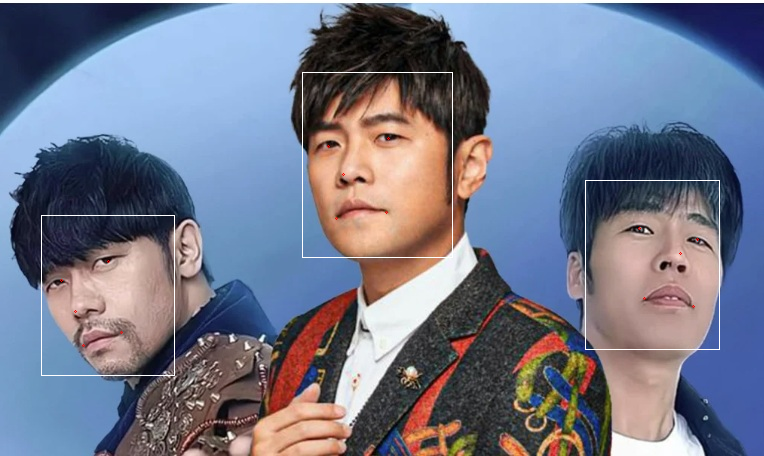

In [95]:
file = './data/test/jay_s.jpg'
image = Image.open(file)
start_time = time.time()
bboxes, landmarks = mtcnn.detect_faces(image, min_face_size=20,thresholds=[0.7, 0.8, 0.9],
                     nms_thresholds=[0.7, 0.7, 0.7], square_bounding_box=False)
print(f'Time: {int((time.time() - start_time) * 1000)} ms')
show_bboxes(image, bboxes, landmarks)

In [96]:
import numpy as np
import torch
from PIL import Image
from face_detector.mtcnn.get_nets import PNet, RNet, ONet
from face_detector.mtcnn.box_utils import nms, calibrate_box, get_image_boxes, convert_to_square, correct_overbound_bboxes
from face_detector.mtcnn.first_stage import run_first_stage
from face_detector.mtcnn.align_trans import get_reference_facial_points, warp_and_crop_face

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pnet = PNet().to(device)
rnet = RNet().to(device)
onet = ONet().to(device)
pnet.eval()
rnet.eval()
onet.eval()
print('')

In [43]:
min_face_size=20
thresholds=[0.7, 0.8, 0.9]
nms_thresholds=[0.7, 0.7, 0.7]

In [89]:
# BUILD AN IMAGE PYRAMID
print(image.size)
width, height = image.size
min_length = min(height, width)

pnet_input_size = 12
factor = 0.707  # sqrt(0.5)

# scales for scaling the image
scales = []

# scales the image so that
# minimum size that we can detect equals to
# minimum face size that we want to detect
m = pnet_input_size/min_face_size
min_length *= m

factor_count = 0
while min_length > pnet_input_size:
    scales.append(m*factor**factor_count)
    min_length *= factor
    factor_count += 1
    
print(len(scales))
scales

(764, 456)
10


[0.6,
 0.42419999999999997,
 0.29990939999999994,
 0.2120359458,
 0.14990941368059996,
 0.10598595547218417,
 0.0749320705188342,
 0.05297697385681578,
 0.03745472051676876,
 0.026480487405355507]

torch.Size([1, 3, 274, 459])
torch.Size([1, 3, 194, 325])
torch.Size([1, 3, 137, 230])
torch.Size([1, 3, 97, 162])
torch.Size([1, 3, 69, 115])
torch.Size([1, 3, 49, 81])
torch.Size([1, 3, 35, 58])
torch.Size([1, 3, 25, 41])
torch.Size([1, 3, 18, 29])
torch.Size([1, 3, 13, 21])


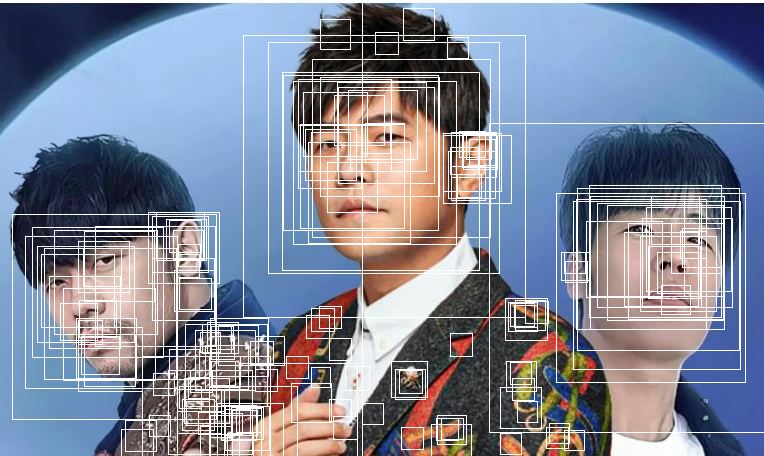

In [97]:
# STAGE 1: P-Net
bboxes = []
landmarks = []
with torch.no_grad():
    # run P-Net on different scales
    for s in scales:
        boxes = run_first_stage(
            image, 
            pnet, 
            scale=s, 
            threshold=thresholds[0], 
            device=device)
        bboxes.append(boxes)
        
bboxes = [i for i in bboxes if i is not None]
bboxes = np.vstack(bboxes)
                
keep = nms(bboxes[:, 0:5], nms_thresholds[0])
bboxes = bboxes[keep]

# use offsets predicted by pnet to transform bounding boxes
bboxes = calibrate_box(bboxes[:, 0:5], bboxes[:, 5:])
                
bboxes = convert_to_square(bboxes)
bboxes[:, 0:4] = np.round(bboxes[:, 0:4])

show_bboxes(image, bboxes, landmarks)

In [ ]:
# Stage 2: R-NET
img_boxes = get_image_boxes(bboxes, image, size=24)
img_boxes = torch.FloatTensor(img_boxes).to(device)
output = rnet(img_boxes)
offsets = output[0].cpu().data.numpy()
probs = output[1].cpu().data.numpy()

keep = np.where(probs[:, 1] > thresholds[1])[0]
bboxes = bboxes[keep]
bboxes[:, 4] = probs[keep, 1].reshape((-1,))
offsets = offsets[keep]

keep = nms(bboxes, nms_thresholds[1])
bboxes = bboxes[keep]
bboxes = calibrate_box(bboxes, offsets[keep])
bboxes = convert_to_square(bboxes)
bboxes[:, 0:4] = np.round(bboxes[:, 0:4])

show_bboxes(image, bboxes, landmarks)

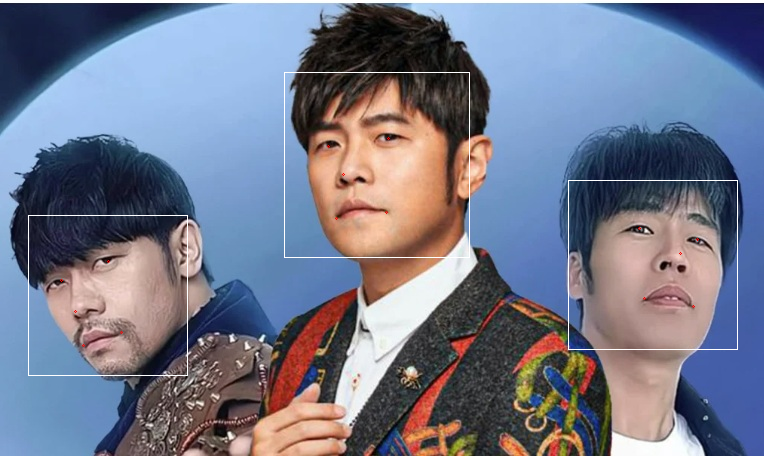

In [79]:
# STAGE 3: O-Net
img_boxes = get_image_boxes(bboxes, image, size=48)
img_boxes = torch.FloatTensor(img_boxes).to(device)
output = onet(img_boxes)
landmarks = output[0].cpu().data.numpy()  # shape [n_boxes, 10]
offsets = output[1].cpu().data.numpy()  # shape [n_boxes, 4]
probs = output[2].cpu().data.numpy()  # shape [n_boxes, 2]

keep = np.where(probs[:, 1] > thresholds[2])[0]
bboxes = bboxes[keep]
bboxes[:, 4] = probs[keep, 1].reshape((-1,))
offsets = offsets[keep]
landmarks = landmarks[keep]

# compute landmark points
width = bboxes[:, 2] - bboxes[:, 0] + 1.0
height = bboxes[:, 3] - bboxes[:, 1] + 1.0
xmin, ymin = bboxes[:, 0], bboxes[:, 1]
landmarks[:, 0:5] = np.expand_dims(xmin, 1) + np.expand_dims(width, 1)*landmarks[:, 0:5]
landmarks[:, 5:10] = np.expand_dims(ymin, 1) + np.expand_dims(height, 1)*landmarks[:, 5:10]

bboxes = calibrate_box(bboxes, offsets)
keep = nms(bboxes, nms_thresholds[2], mode='min')
bboxes = bboxes[keep]
bboxes = correct_overbound_bboxes(bboxes, image.size[0], image.size[1])
bboxes = convert_to_square(bboxes)
landmarks = landmarks[keep]
show_bboxes(image, bboxes, landmarks)